In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

Una consideración importante que debemos tener en cuenta con este código es que las ganancias no pueden compararse directamente entre años distintos, ya que no mantienen la misma magnitud económica. Por lo tanto, es necesario considerar la inflación y la devaluación del dinero.
Para garantizar la comparabilidad, convertimos todos los valores correspondientes a años anteriores a 2024 en su valor presente.

In [3]:
factores_inflacion = {
    2024: 1.00,       # Año Base
    2023: 1.0928,     # Inflación 2023 (9.28%)
    2022: 1.2362,     # Inflación 2023 + 2022 (Acumulada ~23%)
    2021: 1.3057      # Inflación 2023 + 2022 + 2021 (Acumulada ~30%)
}

# Crear columna de factor
df['Factor_Ajuste'] = df['Año de Corte'].map(factores_inflacion)

# Aplicar la corrección a tus columnas monetarias
columnas_dinero = ['INGRESOS OPERACIONALES', 'TOTAL ACTIVOS', 'GANANCIA (PÉRDIDA)',"TOTAL PATRIMONIO","TOTAL PASIVOS"]

for col in columnas_dinero:
    # Creamos la versión "REAL" de la columna
    nombre_real = col + '_REAL'
    df[nombre_real] = df[col] * df['Factor_Ajuste']

La columna tiempo puede representar una variable con un impacto significativo en el entrenamiento del modelo. Sin embargo, definirla únicamente como un valor numérico de tipo int podría derivar en un modelo demasiado simple y con baja capacidad explicativa. Por este motivo, considero importante incorporar las variables económicas presentes en los periodos de análisis del país. De esta manera, las estimaciones del crecimiento empresarial dependerán, como ocurre en la realidad, de las condiciones económicas vigentes. En particular, resulta pertinente incluir columnas como IPC, PIB y TRM, lo que permitirá realizar proyecciones de crecimiento empresarial basadas en variables más consistentes y representativas del entorno económico nacional.

In [39]:
# -----------------------------------------------------------------------------
# 1. DICCIONARIO MACROECONÓMICO (Fuentes: DANE, BanRep, Superfinanciera)
# -----------------------------------------------------------------------------
# PIB: Crecimiento anual del Producto Interno Bruto (%)
# IPC: Inflación anual al cierre de año (%)
# TRM: Tasa de cambio promedio del año (Pesos por Dólar)

datos_macro = {
    2021: {'PIB_Nacional': 10.8,  'IPC_Anual': 5.62,  'TRM_Promedio': 3743.09},
    2022: {'PIB_Nacional': 7.3,   'IPC_Anual': 13.12, 'TRM_Promedio': 4255.44},
    2023: {'PIB_Nacional': 0.6,   'IPC_Anual': 9.28,  'TRM_Promedio': 4325.05},
    2024: {'PIB_Nacional': 1.6,   'IPC_Anual': 5.20,  'TRM_Promedio': 4072.59}, 
    # Nota: 2024 son datos preliminares/cierre estimados por el mercado.
}

def enriquecer_con_macroeconomia(df, col_anio='Año de Corte'):
    """
    Toma el DataFrame original y le agrega 3 columnas macroeconómicas
    basadas en el año de corte de cada empresa.
    """
    # Mapear los valores usando el diccionario
    df['PIB_Nacional'] = df[col_anio].map(lambda x: datos_macro.get(x, {}).get('PIB_Nacional'))
    df['IPC_Anual'] = df[col_anio].map(lambda x: datos_macro.get(x, {}).get('IPC_Anual'))
    df['TRM_Promedio'] = df[col_anio].map(lambda x: datos_macro.get(x, {}).get('TRM_Promedio'))
    
    return df

df = enriquecer_con_macroeconomia(df)

In [40]:
for i in df.columns:
    print(f"La columna {i} tiene un total de {len(df[i].value_counts())} valores unicos")

La columna NIT tiene un total de 13976 valores unicos
La columna RAZÓN SOCIAL tiene un total de 18616 valores unicos
La columna SUPERVISOR tiene un total de 6 valores unicos
La columna REGIÓN tiene un total de 7 valores unicos
La columna DEPARTAMENTO DOMICILIO tiene un total de 41 valores unicos
La columna CIUDAD DOMICILIO tiene un total de 652 valores unicos
La columna CIIU tiene un total de 21 valores unicos
La columna MACROSECTOR tiene un total de 6 valores unicos
La columna INGRESOS OPERACIONALES tiene un total de 454 valores unicos
La columna GANANCIA (PÉRDIDA) tiene un total de 210 valores unicos
La columna TOTAL ACTIVOS tiene un total de 575 valores unicos
La columna TOTAL PASIVOS tiene un total de 399 valores unicos
La columna TOTAL PATRIMONIO tiene un total de 490 valores unicos
La columna Año de Corte tiene un total de 4 valores unicos
La columna Factor_Ajuste tiene un total de 4 valores unicos
La columna INGRESOS OPERACIONALES_REAL tiene un total de 998 valores unicos
La col

In [45]:
df["ROA"]=df["GANANCIA (PÉRDIDA)_REAL"]/df["TOTAL ACTIVOS_REAL"] # Mide la eficiencia con la que una empresa utiliza sus activos para generar ganancias
df["Endeudamiento"] = df["TOTAL PASIVOS_REAL"]/df["TOTAL ACTIVOS_REAL"] # Mide el porcentaje del negocio financiado con deuda
df["Rotacion activos"] = df["INGRESOS OPERACIONALES_REAL"]/df["TOTAL ACTIVOS_REAL"] # Mide qué tan bien la empresa utiliza sus activos para generar ingresos

In [42]:
df_numericas = df.select_dtypes(include=[np.number])
df_numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   INGRESOS OPERACIONALES       40000 non-null  float64
 1   GANANCIA (PÉRDIDA)           40000 non-null  float64
 2   TOTAL ACTIVOS                40000 non-null  float64
 3   TOTAL PASIVOS                40000 non-null  float64
 4   TOTAL PATRIMONIO             40000 non-null  float64
 5   Año de Corte                 40000 non-null  int64  
 6   Factor_Ajuste                40000 non-null  float64
 7   INGRESOS OPERACIONALES_REAL  40000 non-null  float64
 8   TOTAL ACTIVOS_REAL           40000 non-null  float64
 9   GANANCIA (PÉRDIDA)_REAL      40000 non-null  float64
 10  TOTAL PATRIMONIO_REAL        40000 non-null  float64
 11  TOTAL PASIVOS_REAL           40000 non-null  float64
 12  ROA                          38875 non-null  float64
 13  Endeudamiento   

Al calcular los indicadores financieros identificamos la presencia de valores nulos e infinitos. Esto ocurre porque algunas empresas registran activos o pasivos iguales a cero, lo que provoca divisiones por cero y, en consecuencia, errores matemáticos que generan valores infinitos.

Desde una perspectiva de negocio, es importante señalar que una empresa no puede operar con activos iguales a cero. Esta situación podría deberse a que los datos están expresados en magnitudes de billones de pesos, por lo que valores muy pequeños podrían aproximarse a cero durante el registro o procesamiento.

Teniendo en cuenta lo anterior, se propone definir un valor mínimo para las empresas que presentan activos igual a 0, asignándoles un valor de 0,01. De esta manera, es posible conservar registros que pueden ser útiles para el modelo y, al mismo tiempo, evitar la sobreestimación de ciertos indicadores financieros.

In [46]:
VALOR_SUELO = 0.01 
mask_activos_zero = df['TOTAL ACTIVOS'] == 0
df.loc[mask_activos_zero, 'TOTAL ACTIVOS'] = VALOR_SUELO

In [47]:
df["ROA"]=df["GANANCIA (PÉRDIDA)"]/df["TOTAL ACTIVOS"] # Mide la eficiencia con la que una empresa utiliza sus activos para generar ganancias 
df["Endeudamiento"] = df["TOTAL PASIVOS"]/df["TOTAL ACTIVOS"] # Mide el porcentaje del negocio financiado con deuda
df["Rotacion activos"] = df["INGRESOS OPERACIONALES"]/df["TOTAL ACTIVOS"] # Mide qué tan bien la empresa utiliza sus activos para generar ingresos

No usaremos el indicador ROA para entrenar el modelo debido a que requiere de la variable objetivo para su calculo, esto estaría entrenando el modelo con la respuesta.

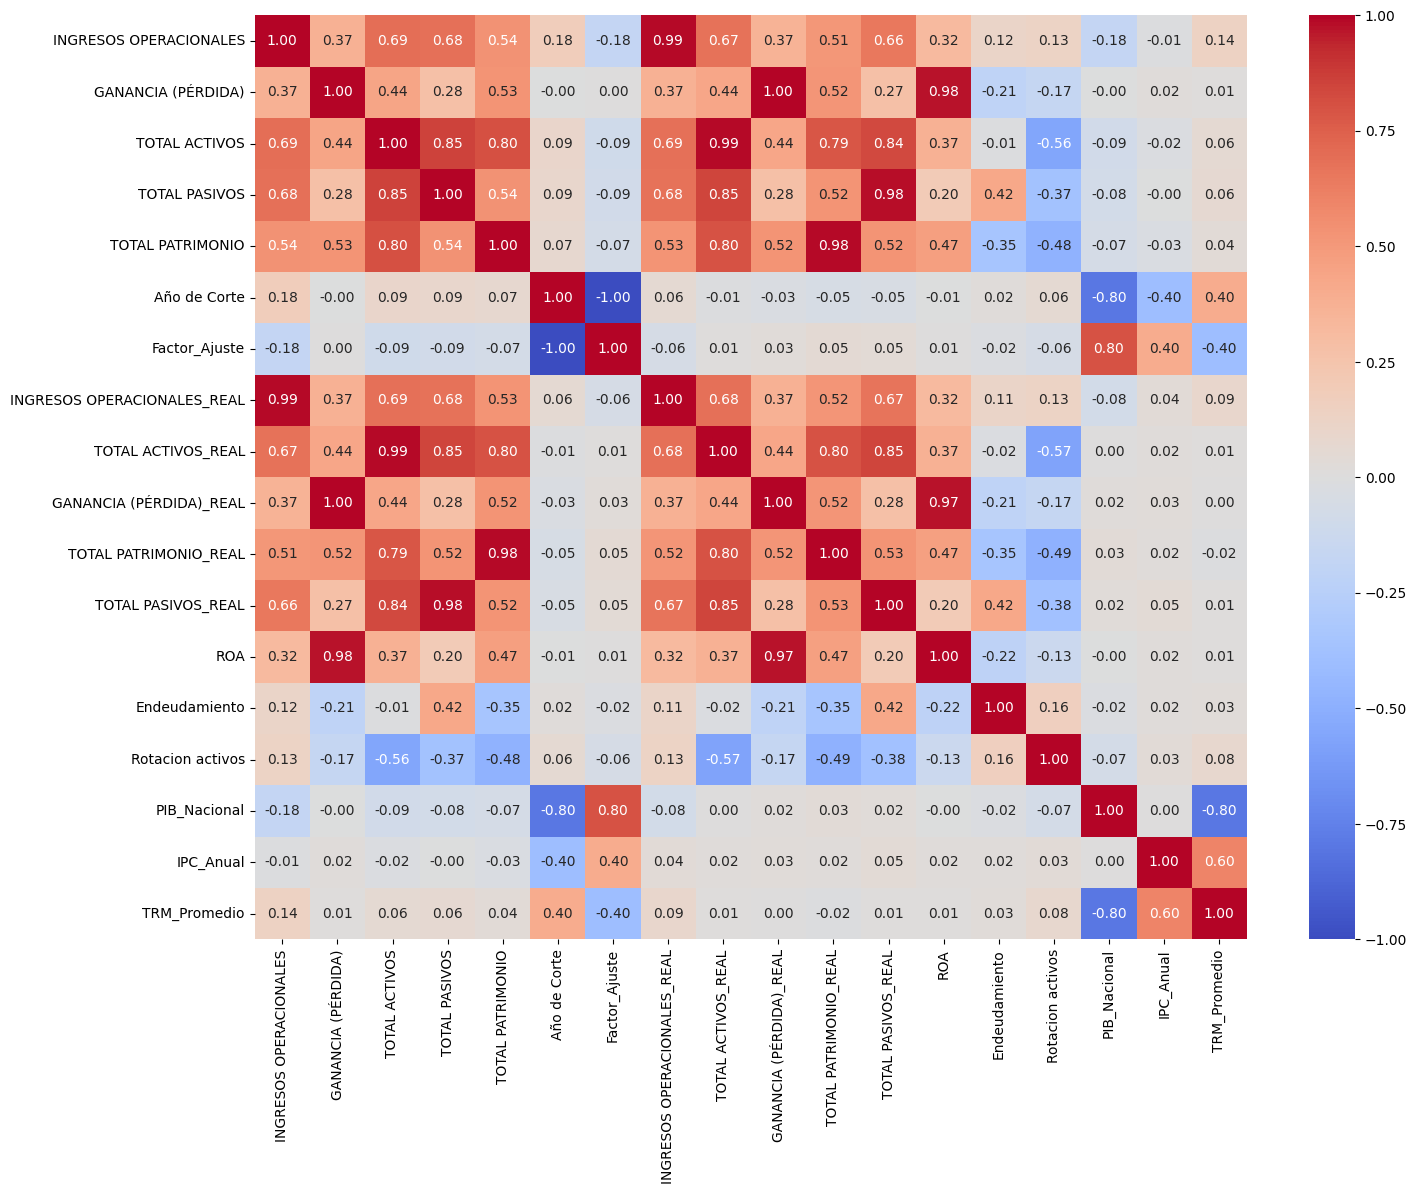

In [48]:
df_numeric = df.select_dtypes(include=[np.number])
matrix_corr=df_numericas.corr("spearman")
plt.figure(figsize=(16, 12))
sns.heatmap(data=matrix_corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()


La columna CIIU aporta un valor significativo, incluso superior al de la columna Macrosector, ya que esta última es demasiado general. No obstante, la columna CIIU presenta inicialmente una alta cardinalidad (418 valores únicos), lo que podría ralentizar el modelo. Por este motivo, como estrategia de procesamiento, considero adecuado agrupar aquellos códigos CIIU que aparecen menos de 450 veces en el dataset. Con esta aproximación se conserva la información más relevante, manteniendo los 20 códigos CIIU más frecuentes y agrupando los demás en una categoría denominada “OTROS”.

In [50]:
a = df["CIIU"].value_counts().sort_values()
resultado = []

for i in a:
    if i > 450:
        resultado.append(i)

print(resultado)
print(len(resultado))

[459, 496, 505, 525, 544, 582, 591, 661, 675, 755, 758, 762, 786, 841, 966, 976, 1008, 1031, 1043, 1374, 24662]
21


In [51]:
top_20_ciiu = df["CIIU"].value_counts().head(20).index

df.loc[~df["CIIU"].isin(top_20_ciiu), "CIIU"] = "Otros"

print(df["CIIU"].value_counts())

CIIU
Otros    25121
8,610     1374
4,631     1043
4,290     1031
4,645     1008
4,663      976
4,111      966
8,621      841
4,731      786
8,010      762
4,664      758
4,659      755
4,690      675
4,511      661
4,711      591
2,229      582
6,810      544
4,530      525
1,410      505
4,620      496
Name: count, dtype: int64


In [66]:
columnas_seleccion =["SUPERVISOR","REGIÓN","DEPARTAMENTO DOMICILIO","CIIU","MACROSECTOR","TOTAL ACTIVOS_REAL","Endeudamiento","Rotacion activos","GANANCIA (PÉRDIDA)_REAL","PIB_Nacional","IPC_Anual","TRM_Promedio","Año de Corte"]
mode_data = df[columnas_seleccion]
mode_data.to_csv('../data/master_table_cleaned.csv', index=False)

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline


# 1. Definir columnas
cols_log_scale = ['TOTAL ACTIVOS_REAL']  # Log + Robust
cols_robust_only = ['Rotacion activos', 'Endeudamiento',"IPC_Anual","PIB_Nacional","TRM_Promedio"] # Solo Robust
cols_categorical = ['MACROSECTOR', 'SUPERVISOR', 'CIIU'] # OneHot

# 2. Construir transformadores
preprocessing = ColumnTransformer(
    transformers=[
        # A. Activos: Logaritmo primero, luego RobustScaler
        ('log_robust', Pipeline([
            ('log', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', RobustScaler())
        ]), cols_log_scale),

        # B. Ratios: Solo RobustScaler
        ('robust', RobustScaler(), cols_robust_only),

        # C. Categóricas: OneHotEncoding
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cols_categorical)
    ],
    remainder='drop' # Ignorar cualquier otra columna que no esté en la lista
)

In [56]:
data_transformer = preprocessing.fit_transform(mode_data)

# Generate feature names manually for each transformer
feature_names = []

# 1. log_robust pipeline (single column)
for col in cols_log_scale:
	feature_names.append(col)

# 2. robust scaler columns
for col in cols_robust_only:
	feature_names.append(col)

# 3. categorical columns (OneHotEncoder)
cat_features = preprocessing.named_transformers_['cat'].get_feature_names_out(cols_categorical)
feature_names.extend(cat_features)
df_procesado = pd.DataFrame(data_transformer, columns=feature_names)
df_procesado.head(5)

,TOTAL ACTIVOS_REAL,Rotacion activos,Endeudamiento,IPC_Anual,PIB_Nacional,TRM_Promedio,MACROSECTOR_AGROPECUARIO,MACROSECTOR_COMERCIO,MACROSECTOR_CONSTRUCCIÓN,MACROSECTOR_MANUFACTURA,...,"CIIU_4,663","CIIU_4,664","CIIU_4,690","CIIU_4,711","CIIU_4,731","CIIU_6,810","CIIU_8,010","CIIU_8,610","CIIU_8,621",CIIU_Otros
0,69.849512,-0.626538,0.192409,1.2,0.417582,0.323482,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,49.651588,-0.642050,-0.276751,1.2,0.417582,0.323482,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28.768470,1.577125,0.234225,1.2,0.417582,0.323482,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,32.618120,0.171368,0.866986,1.2,0.417582,0.323482,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,36.290474,-0.270157,-0.133707,1.2,0.417582,0.323482,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


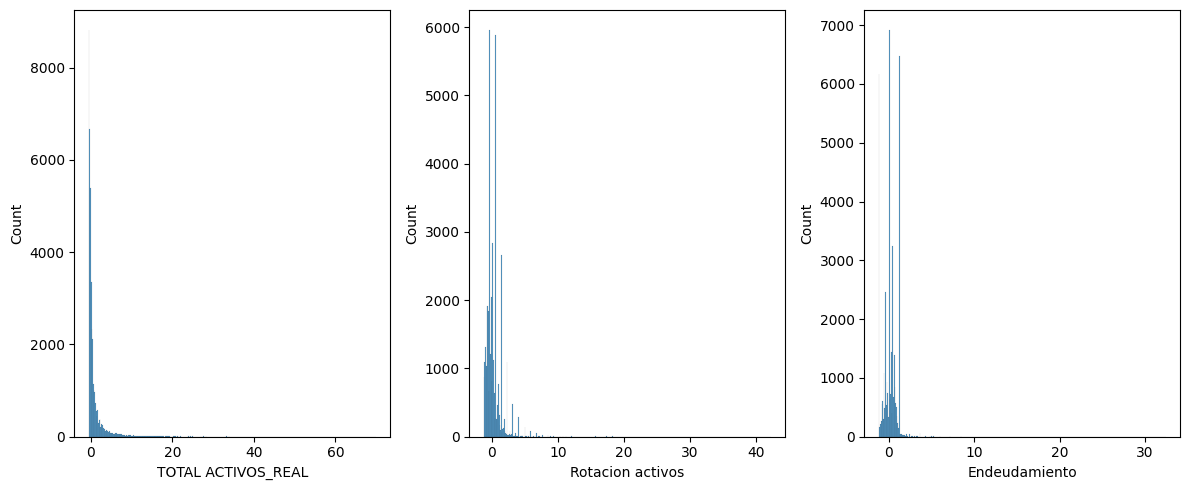

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(data=df_procesado, x="TOTAL ACTIVOS_REAL", bins=400, ax=ax[0])
sns.histplot(data=df_procesado, x="Rotacion activos", bins=400, ax=ax[1])
sns.histplot(data=df_procesado, x="Endeudamiento", bins=400, ax=ax[2])
plt.tight_layout()
plt.show()